# Data Wrangling with Spark  
**Spark SQL** is a spark module for structured data processing.  
One use of Spark SQL is to execute SQL queries.
> [Spark SQL Guide](<https://spark.apache.org/docs/latest/sql-programming-guide.html>)  
  
> [PySpark API Docs](<https://spark.apache.org/docs/latest/api/python/index.html>)  
  
A **DataFrame** is a *Dataset* organized into named columns. It is conceptually equivalent to:
* A table in a relational database;
* A DataFrame in R or Python;  
  
Despite these similarities, Spark DataFrames have richer optimizations running under the hood.

## Start wrangling data
by first import the necessary libraries and modules

In [1]:
# import the SparkSession Class
from pyspark.sql import SparkSession

# import standard SQL functions
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

# create user defined functions with the module below
from pyspark.sql.functions import udf

# import SQL Data Types
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType

# import "standard" Python libraries
import datetime
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## instantiate a new `SparkSession`

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

spark

## Explore the Dataset

In [3]:
# set file path
log_file_path = 'data/sparkify_log_small.json'

# ingest data
user_log = spark.read.json(log_file_path)

user_log.take(1)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046')]

In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+-----+------------+------+-------+--------------------+------------------+--------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length|level|    location|method|   page|        registration|         sessionId|    song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+-----+------------+------+-------+--------------------+------------------+--------+------------------+--------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|              8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|             1000

In [6]:
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [7]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827552|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [8]:
user_log.count()

10000

## chain DataFrame methods
to obtain a list of unique page names listed within the log file:

In [9]:
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



## use `select()`
to retrieve a list of Rows from specific columns.  
  
`where()` acts like SQL's `WHERE` clause, it filters the DataFrame for a specific user in this case.

In [10]:
user_log.select(['userId','firstname','page','song']).where(user_log.userId == '1046').collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

## Calculate statistics by Hour  
Define a custom function with the following steps:
1. create an anonymous function to convert Unix Epoch values to "real timestamps", and then extract the hour from it
2. Nest this anonymous function within Spark SQL's `udf` function
3. Assign this User Defined function to a meaningful name/variable ("get_hour", in this case).


In [11]:
get_hour = udf(lambda unix_epoch: datetime.datetime.fromtimestamp(unix_epoch / 1000.0).hour)

## use `withColumn()`
in conjunction with the `get_hour` custom function to add a new DataFrame column.  
  
`withColumn()` docstring below:
> Returns a new :class:`DataFrame` by adding a column or replacing the
existing column that has the same name.

In [12]:
user_log = user_log.withColumn("hour",get_hour(user_log.ts))

In [13]:
# notice the "hour" column append to original DataFrame below
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22')

## Obtain a count of songs
per hour of song execution. To do this, the following functions are chained:
* `filter()` → it's an alias for the `where()` function;
* `groupBy()` → similar to SQL's `GROUP BY` clause. Beware `groupby()` is an alias for `groupBy()` so they can be used interchangeably;
* `orderBy()` → returns a new DataFrame sorted by the specified columns;
* `count()` → counts the number of items within an aggregation;  
  
**NOTES:** Spark SQL can also create `cubes` and `rollups` like PostreSQL.  
  
> [PySpark SQL Module Docs](<https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#>)

In [14]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupBy(user_log.hour).count().orderBy(user_log.hour.cast("float"))

songs_in_hour.show(n=24)

+----+-----+
|hour|count|
+----+-----+
|   0|  456|
|   1|  454|
|   2|  382|
|   3|  302|
|   4|  352|
|   5|  276|
|   6|  348|
|   7|  358|
|   8|  375|
|   9|  249|
|  10|  216|
|  11|  228|
|  12|  251|
|  13|  339|
|  14|  462|
|  15|  479|
|  16|  484|
|  17|  430|
|  18|  362|
|  19|  295|
|  20|  257|
|  21|  248|
|  22|  369|
|  23|  375|
+----+-----+



## use PySpark DataFrame's `toPandas()`
method to convert from Spark DataFrame to Pandas DataFrame, thus also enabling usage of this library:

In [15]:
type(songs_in_hour)

pyspark.sql.dataframe.DataFrame

In [16]:
songs_in_hour_pd = songs_in_hour.toPandas()

In [17]:
type(songs_in_hour_pd)

pandas.core.frame.DataFrame

In [18]:
songs_in_hour_pd.head()

,hour,count
0,0,456
1,1,454
2,2,382
3,3,302
4,4,352


## Replace the old `hour` column
in the recently created Pandas DataFrame.  
  
To achieve this, use Pandas' `to_numeric()` function upon the "old" `hour` column.

In [19]:
songs_in_hour_pd['hour'] = pd.to_numeric(songs_in_hour_pd['hour'])

## Use `pyplot`
to create a scatter plot graph of the count of the number of songs played per hour:

Text(0, 0.5, 'Songs Played')

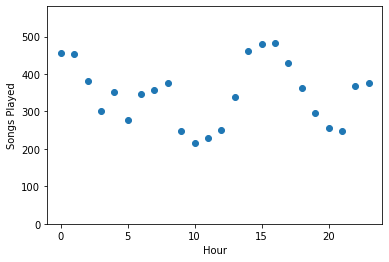

In [20]:
plt.scatter(
     x=songs_in_hour_pd['hour']
    ,y=songs_in_hour_pd['count']
)

# set both x and y ax
plt.xlim(-1,24)
plt.ylim(0,1.2 * max(songs_in_hour_pd['count']))
plt.xlabel('Hour')
plt.ylabel('Songs Played')

## Use PySpark's `dropna()` method
to remove rows having `null` values and/or empty strings

In [21]:
# count empty strings on "userId" column
user_log.filter(user_log['userId'] == '').count()

336

In [22]:
# count empty strings on "sessionId" column
user_log.filter(user_log['sessionId'] == '').count()

0

In [23]:
user_log_valid = user_log.dropna(
     how='any'
    ,subset=['userId','sessionId']
)

user_log_valid.count()

10000

## list the top 10 `userId`
repeating the most in the `user_log` DataFrame.  
> notice the empty string shown in the first position.

In [24]:
# user_log.select('userId').dropDuplicates().sort('userId').show(n=10)

user_log.select('userId').groupBy('userId').count().sort('count',ascending=False).show(n=10)

+------+-----+
|userId|count|
+------+-----+
|      |  336|
|    58|  313|
|  1647|  199|
|  1232|  180|
|   748|  162|
|  2481|  148|
|  1865|  137|
|  1950|  122|
|   462|  122|
|  1806|  121|
+------+-----+
only showing top 10 rows



## recreate the `user_log_valid` DataFrame
this time by filtering out the empty string `user_id` values:

In [25]:
user_log_valid = user_log.filter(user_log['userId'] != '')

# count the number of entries in the new DataFrame
user_log_valid.count()

9664

## Determine users who have downgraded
their accounts from `paid` to `free`.  
  
Below we select all users who have visited the `Submit Downgrade` page:

In [26]:
user_log_valid.select('userId').filter(user_log_valid['page'] == 'Submit Downgrade').show()

+------+
|userId|
+------+
|  1138|
+------+



## Select the entire user activity
for the user we listed in the previous cell  
  
notice the `collect()` method returns all DataFrame Rows, whilst `show()` can be used to return the "first n" rows (by default, `n` equals 20).

In [27]:
user_log_valid.select(['userId','firstName','page', 'level', 'song']).where(user_log_valid['userId'] == '1138').collect()

[Row(userId='1138', firstName='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstName='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

## create a User Defined Function
to evaluate whether an user has downgraded his account.  
This function will be applied upon each DataFrame Row.  
Steps to create this function:  
1. create an anonymous ("lambda") function to evaluate the value within the `page` column;
1. wrap this anonymous function into PySpark `udf()` function;
1. give this User Defined Function a meaningful name ("flag_downgrade_event", in our case);

In [28]:
# create the user defined function
# this function receives the name of the column it'll iterate over
flag_downgrad_event = udf(lambda page: 1 if page == 'Submit Downgrade' else 0, IntegerType())

## add a new column
to the `user_log_valid` Spark DataFrame, by applying the UDF previously created.  
  
**BEWARE:** while the `head()` method displays 1 row by default, it ALWAYS loads the entire DataFrame object to memory. Use it with caution =)

In [29]:
user_log_valid = user_log_valid.withColumn(
     colName='downgraded'
    ,col=flag_downgrad_event('page')
)

user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='22', downgraded=0)

## import PySpark SQL's `Window` class
to enable usage of SQL's `window functions`.  
  
Syntax examples compared to "standard" SQL's are given below:
  
> ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW  
`window = Window.orderBy("date").rowsBetween(Window.unboundedPreceding, Window.currentRow)`  
  
> PARTITION BY country ORDER BY date RANGE BETWEEN 3 PRECEDING AND 3 FOLLOWING  
`window = Window.orderBy("date").partitionBy("country").rangeBetween(-3, 3)`  
  
**Postgres Window Function** calls documentation is available below for reference:  
  
> https://www.postgresql.org/docs/11/sql-expressions.html#SYNTAX-WINDOW-FUNCTIONS  
  
> https://www.postgresqltutorial.com/postgresql-window-function/  
  
**PySpark SQL** Window class documentation:  
> https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Window

In [30]:
from pyspark.sql import Window

## define the window
over which the query will work upon  
> notice PySpark SQL's `desc()` function is used to sort the Unix Epoch values below  
  
> [`desc()` function docs](<https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.desc>)

In [31]:
phase_window = Window \
    .partitionBy('userId') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, Window.currentRow)

## use `withColumn()`
to add a new column to the `user_valid_log` DataFrame

In [32]:
user_log_valid = user_log_valid.withColumn(
     colName='phase'
    ,col=Fsum('downgraded').over(phase_window)
)

In [33]:
# methods are chained below
user_log_valid \
    .select(['userId','firstName','ts','page','level','phase']) \
    .where(user_log_valid['userId'] == '1138') \
    .sort('ts',ascending=True) \
    .collect()

[Row(userId='1138', firstName='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstName='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstName='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstName='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstName='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstName='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstName='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstName='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstName='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstName='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

## Data Wrangling Quiz Responses
Question 1:

In [34]:
user_log.select('page').filter(user_log['userId'] == '').dropDuplicates().sort('page').collect()

[Row(page='About'), Row(page='Help'), Row(page='Home'), Row(page='Login')]

Question 3:

In [39]:
user_log.select('userId').filter(user_log['gender'] == 'F').dropDuplicates().count()

462

Question 4:

In [49]:
# obtain ranking of most played artists
user_log \
    .select('artist') \
    .filter(user_log['artist'] != '') \
    .groupBy('artist') \
    .count() \
    .sort('count',ascending=False) \
    .show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|            Coldplay|   83|
|       Kings Of Leon|   69|
|Florence + The Ma...|   52|
|            BjÃÂ¶rk|   46|
|       Dwight Yoakam|   45|
|       Justin Bieber|   43|
|      The Black Keys|   40|
|         OneRepublic|   37|
|        Jack Johnson|   36|
|                Muse|   36|
|           Radiohead|   31|
|        Taylor Swift|   29|
|               Train|   28|
|Barry Tuckwell/Ac...|   28|
|          Lily Allen|   28|
|           Metallica|   27|
|          Nickelback|   27|
|           Daft Punk|   27|
|          Kanye West|   26|
|Red Hot Chili Pep...|   24|
+--------------------+-----+
only showing top 20 rows



In [52]:
# count of songplays for most played artist, "Coldplay"
user_log.select('song').filter(user_log['artist'] == 'Coldplay').count()

83

Question 5: